# **Methylation Biomarkers for Predicting Cancer**

## **Dimensionality Reduction: Principal Component Anlaysis**

**Author:** Meg Hutch

**Date:** February 09, 2020

**Objective:** Reduce dimensionality of the gene methylation data

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

Load Training and testing sets processed in R

In [2]:
# Training set
mcTrain = pd.read_csv('C:\\Users\\User\\Box Sync/Projects/Multi_Cancer_DL/02_Processed_Data/mcTrain_70_30.csv')
# Testing set
mcTest = pd.read_csv('C:\\Users\\User\\Box Sync/Projects/Multi_Cancer_DL/02_Processed_Data/mcTest_70_30.csv')

**Data Pre-Processing**

Check if any missing values: Nope!

In [3]:
mcTest.columns[mcTest.isna().any()].tolist()
mcTrain.columns[mcTest.isna().any()].tolist()

[]

## **Principal Component Analysis**

We will first conduct dimensionality reduction using principal component analysis

First, subset the training set to only include the methylated gene information

In [4]:
# remove non-gene data from both the training and testing sets
genesTrain = mcTrain.drop(columns=["diagnosis", "dilute_library_concentration", "age", "gender"])

genesTest = mcTest.drop(columns=["diagnosis", "dilute_library_concentration", "age", "gender"])

In [5]:
genesTest.head()

,seq_num,OR4F5,AL627309.1,OR4F29,OR4F16,AL669831.1,AL645608.2,SAMD11,AL645608.1,NOC2L,...,SYCE3,CPT1B,CHKB-CPT1B,CHKB,MAPK8IP2,ARSA,SHANK3,ACR,RABL2B,frag_mean
0,SEQF2033,0,44,0,0,13,12,166,0,268,...,127,0,21,137,132,149,1113,126,100,189.964583
1,SEQF2037,1,35,0,0,7,11,188,0,300,...,123,0,19,139,151,197,1249,156,101,179.389458
2,SEQF2038,1,15,0,0,19,11,200,0,307,...,158,1,21,171,164,148,1251,126,143,178.434177
3,SEQF2043,0,24,0,0,11,10,268,0,345,...,126,0,28,168,178,190,1491,117,123,174.410419
4,SEQF2044,3,19,0,0,9,14,174,0,243,...,114,1,32,138,152,183,1209,130,118,182.483672


Create patient seq_num id index

In [6]:
## Training set
# Convert patinet_ids to row names 
genesTrain = genesTrain.set_index(genesTrain.seq_num)

# Remove seq_num as a column
genesTrain = genesTrain.drop(columns=["seq_num"])

# Create a list of row names
patients = list(genesTrain.index)

## Testing set
# Convert patinet_ids to row names 
genesTest = genesTest.set_index(genesTest.seq_num)

# Remove seq_num as a column
genesTest = genesTest.drop(columns=["seq_num"])

# Create a list of row names
patientsTest = list(genesTest.index)

# **1) Standardize Dataset**

We will scale the data prior to performing PCA on the training set. 

**StandardScaler** helps standardize features onto unit scale (mean = 0 and standard deviation = 1). Thus, each value in the dataset will have the sample mean value subtracted and then divided by the standard deviation of the whole dataset. 


In [7]:
# pca packages
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA

# Stanardize/Scale the data
x = StandardScaler().fit_transform(genesTrain.astype(np.float)) # no errors  

In [8]:
# manual check that the StandardScaler().fit_transform is correctly scaling the data - look good
#genesTrain.head()
#np.mean(genesTrain['OR4F5'])
#np.std(genesTrain['OR4F5'])

#np.mean(genesTrain['AL627309.1'])
#np.std(genesTrain['AL627309.1'])

**Check whether the normalized data has a mean of zero and a standard deviation of 1:**

In [9]:
np.mean(x), np.std(x)

(-1.2297270330446118e-20, 0.9611041936947506)

**Standardize the Test Set**

To standardize each column of the test set, we need to subtract the mean of the training data and then divide by the standard deviation of the training data.

In [10]:
# Functions to calculate mean and sd of each column 
genesTrain_mean = genesTrain.mean()
genesTrain_sd = genesTrain.std()

Transpose the mean and sd datasets in order to faciliate the calculations with the testing sets

In [11]:
# Transpose the mean dataset
genesTrain_mean = pd.DataFrame(genesTrain_mean)
genesTrain_mean = genesTrain_mean.transpose()

# add duplicated rows to match the number of rows in the test set (100 samples) - this will faciliate the subtraction and standard deviation division
genesTrain_mean = pd.concat([genesTrain_mean]*100)

# Transpose the sd dataset
genesTrain_sd = pd.DataFrame(genesTrain_sd)
genesTrain_sd = genesTrain_sd.transpose()
# add duplicated rows to match the number of rows in the test set

# Add duplicated rows to the sd dataset
genesTrain_sd = pd.concat([genesTrain_sd]*100)

In [12]:
# remove index
genesTest.reset_index(level=0, inplace=True)
# Drop seq_num column
genesTest = genesTest.drop(columns=["seq_num"])

**Replace 0s with 0.01 in order to not get NA values - is this koshure?**

In [13]:
genesTrain_sd = genesTrain_sd.replace(0, 0.0000000001)

**Subtract each value in the Test set by the training set mean and divide by the training set standard deviation**

In [14]:
# Subtract the mean values from the genesTest
genesTest = pd.DataFrame(genesTest.values-genesTrain_mean.values, columns=genesTest.columns)

# Divide the trained mean subtracted values by standard deviation of the training set
genesTest = pd.DataFrame(genesTest.values/genesTrain_sd.values, columns=genesTest.columns)

**Remove any genes that have NAs**

Because we converted 0s to NA, none of these are NAs

In [15]:
genesTest = genesTest.dropna(axis = 1) # by indicating axis = 1, we are able to drop any genes that have become NAs === are we still have to perform PCA now? 

**Convert the normalized features into tabular format**

In [16]:
# Create list of column names
features = list(genesTrain.columns.values) 

# Create data frame of newly normalized data - use patients IDs as the index 
x = pd.DataFrame(x, columns = features, index = patients)

# **2) Determine Prinicpal Components**

Reference: https://stackoverflow.com/questions/42167907/understanding-scikitlearn-pca-transform-function-in-python

**pca.fit** allows PCA function to compute vectors that you can project your data onto in order to reduce the dimensionality of your data.

**pca.transform** actually performs the projection. It projects each row of data into the vector space that was learned when fit was called.

from sklearn: **fit_transform**: Fit the model with X and apply the dimensionality reduction on X

In [17]:
## Define pca function
pca = PCA()

# Fit to the scaled/standardized data - then use transform to prokect into the new vector space learned by fit
principalComponents = pca.fit_transform(x)

# Generate a list of column names with the number for each prinicpal component 
col_names = [f'pc{i}' for i in range(1, 243)] # there are 242 samples - so we want to have range of 1 less than 243 column names 

# Add column names to the principal component dataset 
principalDf_ALL = pd.DataFrame(principalComponents, columns = col_names, index = patients)

**3) Determine # of Components and Variance**

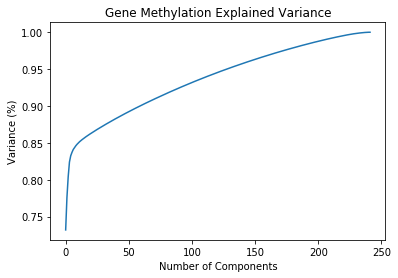

In [18]:
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Gene Methylation Explained Variance')
plt.savefig('C:\\Users\\User\\Box Sync/Projects/Multi_Cancer_DL/04_Results/Component_%Variance.png')
plt.show()

**Alternative method - Pre-selecting % of variance**

When we fit the PCA classifier and transform x after specifying 90%, we get 60 principal components representing 90% of the variance.

In [19]:
pca = PCA(0.9)
genesTrain_transformed = pca.fit_transform(x)

pca.n_components_ 

60

**Define PC column names and create dataframe**

In [20]:
# Define new pc column names (up to pc60)
col_names = [f'pc{i}' for i in range(1, 61)] 

# Add column names to the principal component dataset 
genesTrain_transformed = pd.DataFrame(genesTrain_transformed, columns = col_names, index = patients)

**Scree Plot**

View which principal components contribute most to the variance 

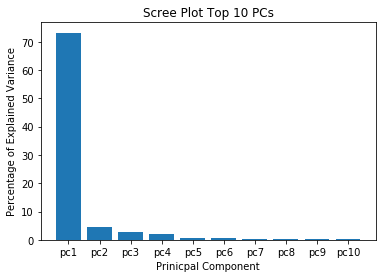

In [21]:
# remove PC from 
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
per_var = per_var[:10] #top 10 PC - this number is chosen just so that we can more easily view the plot
labels = col_names[:10]

plt.bar(x=range(1, len(per_var)+1), height = per_var, tick_label = labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Prinicpal Component')
plt.title('Scree Plot Top 10 PCs')
plt.savefig('C:\\Users\\User\\Box Sync/Projects/Multi_Cancer_DL/04_Results/PCA_Screeplot.png')
plt.show()

# **4) Project prinicipal components onto the test set**

In [22]:
genesTest_transformed = pca.transform(genesTest)

When converted to a dataframe, we can see that the test set has been transformed into 60 principal components

In [23]:
genesTest_transformed = pd.DataFrame(data = genesTest_transformed, columns = col_names, index = patientsTest)
genesTest_transformed

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,...,pc51,pc52,pc53,pc54,pc55,pc56,pc57,pc58,pc59,pc60
SEQF2033,-102.841318,1.773440,28.062254,-9.977955,-18.753982,8.228217,-10.597418,4.092870,-2.385132,0.054784,...,0.486064,-1.704583,-0.341936,-0.992249,0.566840,1.015505,0.815272,0.640567,1.264112,1.126230
SEQF2037,-83.301300,-1.558423,-4.480817,4.436386,-11.588451,13.752957,3.686251,-5.755789,-0.749609,5.026762,...,1.353695,2.417321,0.522615,0.962005,-0.070286,1.368225,-0.732258,-0.559259,0.517676,-1.260989
SEQF2038,-117.420933,52.965973,16.114735,-29.205741,-23.005133,7.806690,6.897661,-6.601067,-6.639167,2.519144,...,0.038496,-0.413014,-0.486456,2.090349,0.610822,-0.969068,-0.458501,0.460774,-0.399764,-0.100249
SEQF2043,-91.733224,96.657169,-17.280867,-19.070306,-9.053843,0.925194,10.062113,-17.111608,-11.380191,2.291609,...,2.735976,0.341657,-0.013045,0.229348,2.642213,0.767085,0.353554,0.091206,0.319725,-1.314914
SEQF2044,-65.095761,-10.298801,20.441959,-3.138325,-3.926847,-5.384682,13.541395,2.511628,-4.597695,-3.482510,...,0.131111,0.470214,-0.351072,0.226380,0.634808,-0.200248,0.101695,1.472392,-0.965918,1.990459
SEQF2057,-39.632103,-21.794803,-4.146097,-0.628237,-1.766154,-0.562631,-8.839796,5.599335,-3.759391,-0.249043,...,0.958885,-0.583203,0.930582,-0.134722,0.381432,-0.288625,0.044055,-2.313021,0.546708,1.697684
SEQF2059,-65.136879,102.131302,-36.979737,26.828683,-23.544657,-6.963477,-1.318476,-9.161071,-7.156064,6.693724,...,0.448166,0.543128,0.693238,-0.377742,2.235275,-1.768188,-1.786514,-0.573766,1.741968,-1.020329
SEQF2062,-30.143971,-29.621647,-17.619902,-6.827107,11.153542,6.544761,-0.834556,-4.207960,0.495751,3.381089,...,0.773549,1.636445,1.922728,0.847281,0.093508,-0.096210,0.007414,-1.260475,0.332705,-0.110259
SEQF2130,-150.420887,35.122946,2.111658,-5.294831,-18.756537,14.638694,-6.501206,-1.441745,8.384967,-9.713691,...,-0.063544,0.022865,-0.064337,-1.440076,1.927299,0.941634,-0.057928,-0.779492,0.639069,0.629085
SEQF2131,-170.147074,-12.916582,14.561034,-4.624720,-12.757094,9.494663,-2.963417,-3.201103,2.609065,3.070534,...,0.440398,-0.782562,-0.598861,-1.792909,-0.971002,-0.974703,-0.258602,-1.370769,0.146186,-0.088581


# **5) Save PCA Components**

In [24]:
#principalDf_ALL.to_csv('C:\\Users\\User\\Box Sync/Projects/Multi_Cancer_DL/02_Processed_Data/principalDF_ALL.csv')
genesTrain_transformed.to_csv('C:\\Users\\User\\Box Sync/Projects/Multi_Cancer_DL/02_Processed_Data/genesTrain_transformed_90pc_30_70.csv')
genesTest_transformed.to_csv('C:\\Users\\User\\Box Sync/Projects/Multi_Cancer_DL/02_Processed_Data/genesTest_transformed_90pc_30_70.csv')